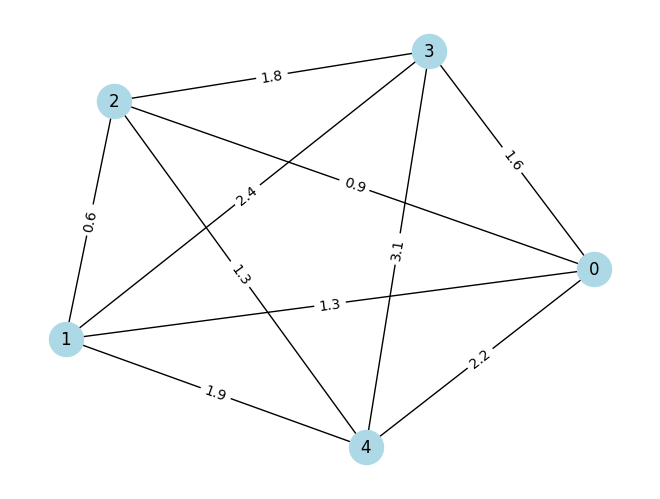

C:\Users\abhis\AppData\Local\Temp\ipykernel_60888\2865789554.py:95: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]
<IBMBackend('ibm_sherbrooke')>
AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['id', 'measure', 'x', 'ecr', 'reset', 'sx']>)


In [1]:
### =============================================================================
### 1) Imports & Setup
### =============================================================================
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit.library import IGate, XGate, YGate, ZGate
from qiskit.circuit import QuantumRegister
from qiskit.quantum_info import Operator, pauli_basis
from typing import Optional, List
import matplotlib.pyplot as plt
import random 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram

### =============================================================================
### 2) Problem Definition: TSP Graph
### =============================================================================
cities = ["A", "B", "C", "D", "E"]
distance_matrix = np.array([
    [0,   1.3, 0.9, 1.6, 2.2],
    [1.3, 0,   0.6, 2.4, 1.9],
    [0.9, 0.6, 0,   1.8, 1.3],
    [1.6, 2.4, 1.8, 0,   3.1],
    [2.2, 1.9, 1.3, 3.1, 0  ]
])

graph = rx.PyGraph()
graph.add_nodes_from(range(len(cities)))
for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        graph.add_edge(i, j, distance_matrix[i][j])

draw_graph(graph, node_size=600, with_labels=True,
           node_color='lightblue', edge_labels=lambda w: f"{w:.1f}")
plt.show()

### =============================================================================
### 3) Hamiltonian Construction
### =============================================================================
def build_tsp_hamiltonian(graph: rx.PyGraph, penalty: float = 1000) -> SparsePauliOp:
    n = len(graph.nodes())
    terms = []

    for i in range(n):
        base = ["I"] * (n*n)
        for t in range(n):
            base[i*n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2/n)))

    for t in range(n):
        base = ["I"] * (n*n)
        for i in range(n):
            base[i*n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2/n)))

    for i, j, w in graph.weighted_edge_list():
        for t in range(n):
            base = ["I"] * (n*n)
            base[i*n + t] = "Z"
            base[j*n + ((t+1) % n)] = "Z"
            terms.append(("".join(base), w / 4))

    return SparsePauliOp.from_list(terms)

tsp_hamiltonian = build_tsp_hamiltonian(graph)

### =============================================================================
### 4) QAOA Circuit
### =============================================================================
reps = 2
qaoa = QAOAAnsatz(cost_operator=tsp_hamiltonian, reps=reps)
init_angles = np.random.rand(qaoa.num_parameters)
qc = qaoa.assign_parameters(init_angles, inplace=False)
qc.measure_all()

### =============================================================================
### 5) Noise-Aware Device & Error Map Extraction
### =============================================================================
service = QiskitRuntimeService()
dev_list = service.backends(
    filters = lambda x: x.configuration().n_qubits >= 5,
    simulator = False)
print(dev_list)
# Select least busy backend
dev = service.least_busy(min_num_qubits=5, simulator=False, operational=True)
print(dev)
seed_sim = 42
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)
print(noisy_fake_backend)

Level 0: Time = 0.112s, Depth = 3416
Level 1: Time = 0.126s, Depth = 1556
Level 2: Time = 0.393s, Depth = 1499
Level 3: Time = 0.991s, Depth = 1251


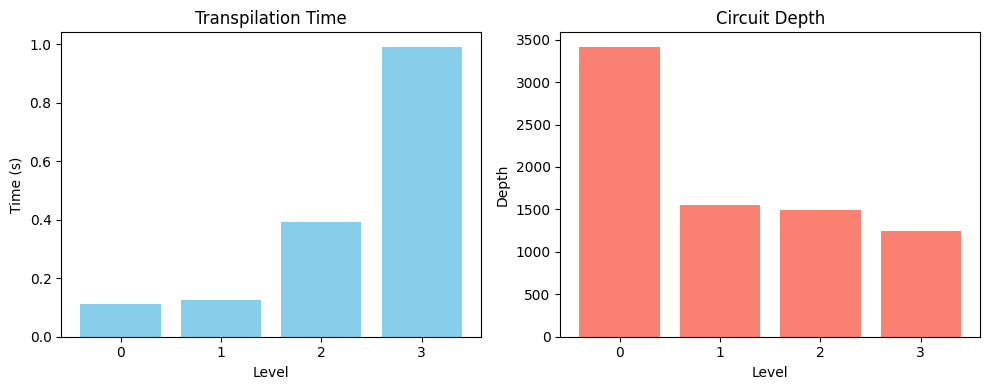

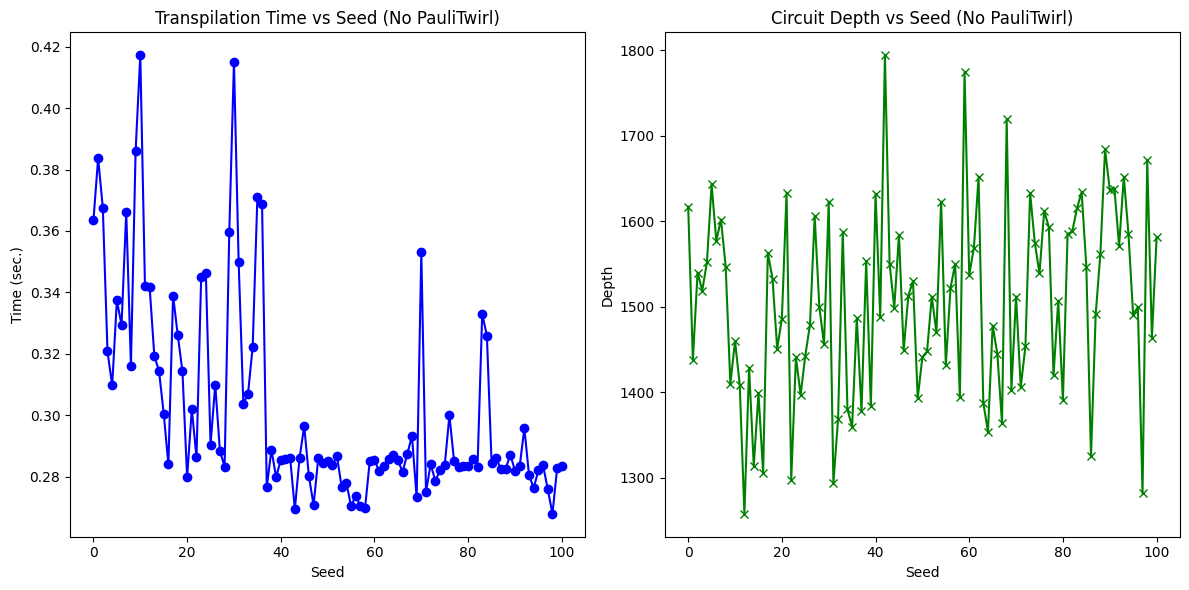


Best transpiler seed: 12 with depth = 1258


In [3]:
### 7) Transpiler Benchmarking
### =============================================================================
import time
optimization_levels = [0, 1, 2, 3]
times, depths = [], []

for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=level)
    start = time.time()
    out = pm.run(qc)
    times.append(time.time() - start)
    depths.append(out.depth())
    print(f"Level {level}: Time = {times[-1]:.3f}s, Depth = {depths[-1]}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time'); plt.xlabel('Level'); plt.ylabel('Time (s)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth'); plt.xlabel('Level'); plt.ylabel('Depth')
plt.tight_layout(); plt.show()
### =============================================================================
### 8) Benchmarking Transpiler Seed Sensitivity (No PauliTwirl)
### =============================================================================
times, depths = [], []
seed_values = list(range(101))  # Seeds 0 to 100

for seed in seed_values:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=2,
        seed_transpiler=seed
    )
    
    start = time.time()
    result_qc = pm.run(qc)
    dt = time.time() - start

    times.append(dt)
    depths.append(result_qc.depth())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed (No PauliTwirl)')
plt.xlabel('Seed')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed (No PauliTwirl)')
plt.xlabel('Seed')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()

# Summary
min_depth_idx = depths.index(min(depths))
print(f"\nBest transpiler seed: {seed_values[min_depth_idx]} with depth = {depths[min_depth_idx]}")

In [8]:
max_readout_error = 0.015
max_single_gate_error = 0.01
max_cx_error = 0.03

Noise_dict, read_err, single_gate_errors, two_q_error_map = dict(), [0]*dev.num_qubits, [0]*dev.num_qubits, {}
for gate, prop_dict in noisy_fake_backend.target.items():
    if prop_dict is None or None in prop_dict:
        continue
    for qargs, inst_props in prop_dict.items():
        if inst_props is None:
            continue
        if gate == "measure" and inst_props.error:
            read_err[qargs[0]] = inst_props.error
        elif len(qargs) == 1 and inst_props.error:
            single_gate_errors[qargs[0]] = max(single_gate_errors[qargs[0]], inst_props.error)
        elif len(qargs) == 2 and inst_props.error:
            two_q_error_map[qargs] = max(two_q_error_map.get(qargs, 0), inst_props.error)

good_qubits = [q for q in range(dev.num_qubits) if read_err[q] <= max_readout_error and single_gate_errors[q] <= max_single_gate_error]
good_cx_edges = [q for q, err in two_q_error_map.items() if err <= max_cx_error and q[0] in good_qubits and q[1] in good_qubits]
bad_qubits = [q for q in range(dev.num_qubits) if q not in good_qubits]


In [9]:
print(f"Good qubits: {good_qubits}")
print(f"Bad qubits: {bad_qubits}")  

Good qubits: [0, 4, 10, 11, 26, 29, 31, 32, 36, 40, 41, 43, 44, 45, 55, 65, 69, 70, 73, 74, 79, 80, 81, 82, 86, 88, 91, 94, 95, 99, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 116, 120, 121, 122, 123, 124, 125]
Bad qubits: [1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 33, 34, 35, 37, 38, 39, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 71, 72, 75, 76, 77, 78, 83, 84, 85, 87, 89, 90, 92, 93, 96, 97, 98, 100, 101, 102, 109, 115, 117, 118, 119, 126]
